In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

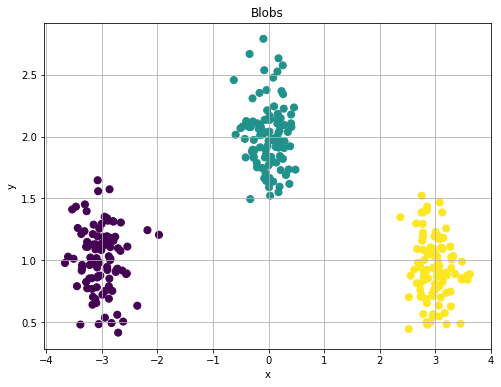

In [2]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))

plt.figure(figsize=(8,6));
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);
plt.grid(True);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Blobs");

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        
        :param estimator: binary base classifier used
        :param n_classes: number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """This should fit one classifier for each class.
        
        self.estimators[i] should be fit on class i vs rest
        :param X: array-like, shape = [n_samples,n_features], input data
        :param y: array-like, shape = [n_samples,] class labels
        :return: returns self
        """
        for i, estimator in enumerate(self.estimators):
            z = 2.0 * (y == i) - 1.0
            estimator.fit(X, z)
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """Returns the score of each input for each class 
        
        Assumes that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        
        :param X: array-like, shape = [n_samples, n_features] input data
        :return: array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        class_scores = np.zeros((X.shape[0], self.n_classes))
        for i, estimator in enumerate(self.estimators):
            class_scores[:,i] = estimator.decision_function(X)      
        
        return class_scores
    
    def predict(self, X):
        """Predict the class with the highest score
        
        :param X: array-like, shape = [n_samples,n_features] input data
        :return: array-like, shape = [n_samples,] the predicted classes for each input
        """
        class_scores = self.decision_function(X)
        return np.argmax(class_scores, axis=1)

Coeffs 0
[[-1.05852747 -0.90296521]]
Coeffs 1
[[ 0.22117096 -0.38900908]]
Coeffs 2
[[ 0.89162796 -0.82467394]]


/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


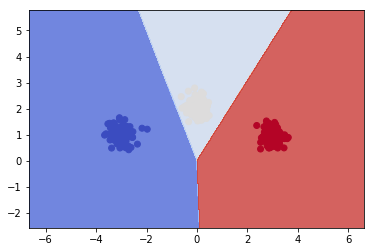

In [4]:
#Here we test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X, y)

for i in range(3) :
    print(f"Coeffs {i}")
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0]) - 3, max(X[:,0]) + 3
y_min, y_max = min(X[:,1]) - 3, max(X[:,1]) + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);


In [5]:
from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

Multiclass SVM

In [6]:
def zero_one(y: np.ndarray, a: np.ndarray) :
    '''Computes the zero-one loss
    
    :param y: output class
    :param a: predicted class
    :return: 1 if different, 0 if same
    '''
    return int(y != a)

def feature_map(X, y, n_classes: int) :
    '''Computes the class-sensitive features
    
    :param X: array-like, shape = [n_samples, n_in] or [n_in,], input features for input data
    :param y: a target class (in range 0,..,n_classes - 1)
    :param n_classes: number of target classes
    :return: array-like, shape = [n_samples, n_out], the class sensitive features for class y
    '''
    n_samples, n_in = (1, X.size) if X.ndim == 1 else X.shape
    n_out = n_classes * n_in
    psi = np.zeros((n_samples, n_out))
    
    if n_samples == 1:
        start_index = y * n_in
        end_index = start_index + n_in
        psi[0,start_index:end_index] = X
    else:
        for i in range(n_samples):
            start_index = y[i] * n_in
            end_index = start_index + n_in
            psi[i, start_index:end_index] = X[i,:]
    return psi

def sgd(X, y, n_out:int, subgd, eta: float=0.1, epochs: int=1000):
    '''Runs subgradient descent, and outputs resulting parameter vector
    
    :param X: array-like, shape = [n_samples, n_features], input training data 
    :param y: array-like, shape = [n_samples,], class labels
    :param n_out: number of class-sensitive features
    :param subgd: function taking x,y and giving subgradient of objective
    :param eta: learning rate for SGD
    :param T: maximum number of iterations
    :return: vector of weights
    '''
    n_samples, _ = X.shape
    weights = np.zeros(n_out)
    
    indices = np.arange(n_samples)
    for i in range(epochs):
        np.random.shuffle(indices)
        for j in indices:
            weights -= eta * subgd(X[j,:], y[j], weights)
    return weights

class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''Implements a Multiclass SVM estimator'''
    def __init__(self, n_out: int, lam: float=1.0, n_classes: int=3, delta=zero_one, psi=feature_map):       
        '''Creates a MulticlassSVM estimator
        
        :param n_out: number of class-sensitive features produced by psi
        :param lam: l2 regularization parameter
        :param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        :param delta: class-sensitive loss function taking two arguments (i.e., target margin)
        :param psi: class-sensitive feature map taking two arguments
        '''
        self.n_out = n_out
        self.lam = lam
        self.n_classes = n_classes
        self.delta = delta
        self.psi = lambda X, y : psi(X, y, n_classes)
        self.fitted = False
    
    def subgradient(self, x, y, w):
        '''Computes the subgradient at a given data point x,y
        
        :param x: sample input
        :param y: sample class
        :param w: parameter vector
        :return: returns subgradient vector at given x,y,w
        '''
        true_featmap = self.psi(x, y)
        feat_maps = np.zeros((self.n_classes, true_featmap.size))
        for i in np.arange(self.n_classes): 
            feat_maps[i, :] = true_featmap - self.psi(x, i)
        class_scores = 1 - feat_maps.dot(w)
        pred_label = np.argmax(class_scores)
        dreg = 2 * self.lam * w
        ddata = -feat_maps[pred_label, :]

        return dreg + ddata
        
    def fit(self, X, y, eta=0.1, epochs=10000):
        '''Fits multiclass SVM
        
        :param X: array-like, shape = [num_samples,num_inFeatures], input data
        :param y: array-like, shape = [num_samples,], input classes
        :param eta: learning rate for SGD
        :param T: maximum number of iterations
        :return: self
        '''
        self.coef_ = sgd(X, y, self.n_out, self.subgradient, eta, epochs)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''Returns the score on each input for each class. Assumes
        that fit has been called.
        
        :param X : array-like, shape = [n_samples, n_in]
        :return: array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        W = self.coef_.reshape((self.n_classes, -1)).T
        return X @ W
            
    def predict(self, X):
        '''Predict the class with the highest score.
        
        :param X: array-like, shape = [n_samples, n_in], input data to predict
        :return array-like, shape = [n_samples,], class labels predicted for each data point
        '''
        class_scores = self.decision_function(X)
        return np.argmax(class_scores, axis=1)

w: [-5.14748980e-10  3.01805016e-12 -2.00932911e-10  3.29705584e-10
  7.15681891e-10 -3.32723634e-10]


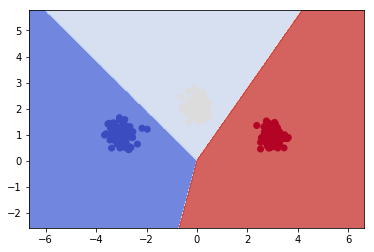

In [7]:
# the following code tests the MulticlassSVM and sgd
est = MulticlassSVM(6, lam=1)
est.fit(X, y, epochs=2000)
print(f"w: {est.coef_}")
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8);

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

In [8]:
from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])